In [1]:
import os
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scprep
import numpy as np
from pyplink import PyPlink
import tqdm
from sklearn.decomposition import PCA
import phate

os.chdir('../../src')
import mappings
import data_loader

In [2]:
# Load HGDP
exp_path = '/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP'
fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnet'
data_path = os.path.join(exp_path, fname)

pedfile = PyPlink(data_path)

In [3]:
all_samples = pedfile.get_fam()
all_samples.head()

,fid,iid,father,mother,gender,status
0,CHMI_CHMI3_WGS2,CHMI_CHMI3_WGS2,0,0,0,-9
1,HG00096,HG00096,0,0,0,-9
2,HG00097,HG00097,0,0,0,-9
3,HG00099,HG00099,0,0,0,-9
4,HG00100,HG00100,0,0,0,-9


In [4]:
print(all_samples.loc[1:,:]['father'].astype(int).unique())
print(all_samples.loc[1:,:]['mother'].astype(int).unique())
print(all_samples.loc[1:,:]['gender'].astype(int).unique())
print(all_samples.loc[1:,:]['status'].astype(int).unique())

[0]
[0]
[0]
[-9]


In [5]:
all_markers = pedfile.get_bim()
all_markers.head()

,chrom,pos,cm,a1,a2
snp,,,,,
1:858952:G:A,1,858952,0,A,G
1:905373:T:C,1,905373,0,C,T
1:911428:C:T,1,911428,0,T,C
1:918870:A:G,1,918870,0,G,A
1:931513:T:C,1,931513,0,C,T


In [6]:
try:
    genotypes_array = np.load(exp_path + '_raw_genotypes.npy')
except:
    genotypes_array = np.zeros([pedfile.get_nb_samples(), pedfile.get_nb_markers()], dtype=np.int8)

    for i, (marker_id, genotypes) in tqdm.tqdm(enumerate(pedfile)):
        genotypes_array[:,i] = genotypes

    np.save(exp_path + '_raw_genotypes.npy', genotypes_array)

In [7]:
genotypes_array.shape

(4151, 228396)

In [8]:
labels = pd.read_csv('/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.reduced.tsv', sep='\t')
labels = labels[1:] # remove first row

In [9]:
def make_palette_label_order_HGDP(populations, superpopulations):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(mappings.pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = mappings.pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(mappings.label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(superpopulations):
        for pop in np.unique(populations[superpopulations==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(mappings.pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(superpopulations):
        for pop in np.unique(populations[superpopulations==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(labels['Population'],
                                                                                                                               labels['Genetic_region'])

In [10]:
# Fit PCA model
pca_obj = PCA(n_components=100)  # Number of components to keep
pca_obj.fit(genotypes_array[1:,:])
pca_input = pca_obj.transform(genotypes_array[1:,:])

In [11]:
phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform(pca_input)

Running PHATE on 4150 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 1.00 seconds.
  Calculating affinities...
  Calculated affinities in 0.26 seconds.
Calculated graph and diffusion operator in 1.26 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.23 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.32 seconds.
Calculated landmark operator in 2.30 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.94 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.98 seconds.


Text(0.5, 1.0, 'PHATE of HGDP')

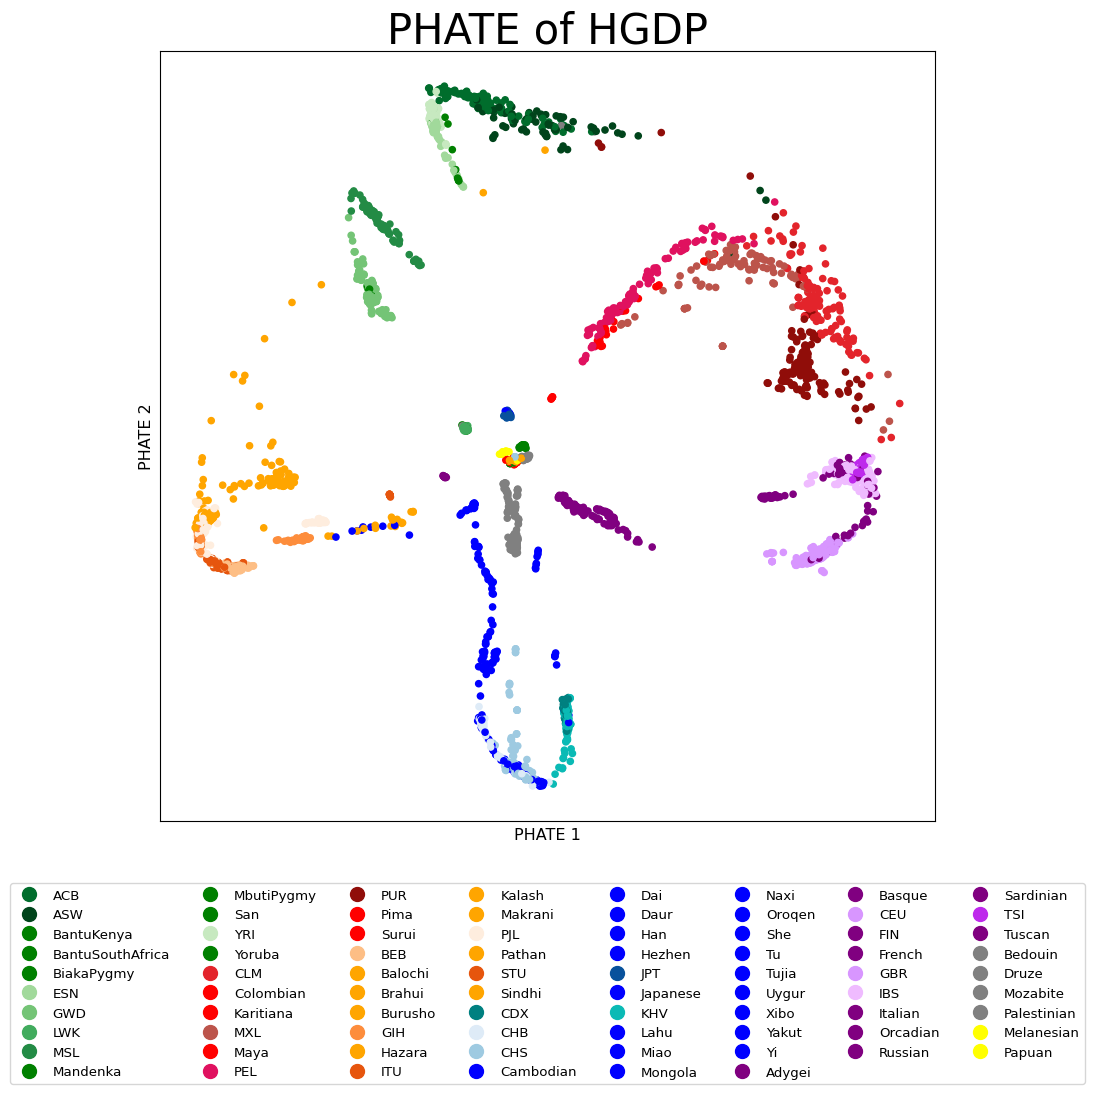

In [12]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(phate_emb, 
                      s=20, 
                      cmap=pop_palette_hgdp_fine, ax=ax,
                      c=labels['Population'], 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

ax.set_title("PHATE of HGDP", fontsize=30)

In [13]:
pd.DataFrame({'id': all_samples['fid'][1:], 'PHATE1': phate_emb[:,0], 'PHATE2': phate_emb[:,1]}).to_csv(os.path.join(exp_path, fname) + 'PHATE_emb_all1kgp+hgdp.csv')
print(os.path.join(exp_path, fname) + 'PHATE_emb_all1kgp+hgdp.csv')

/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnetPHATE_emb_all1kgp+hgdp.csv


## Run PCA+PHATE on 1KGP and Project HGDP on it

In [14]:
# Fit PCA model
pca_obj_1KGP = PCA(n_components=100)  # Number of components to keep
pca_obj_1KGP.fit(genotypes_array[1:,:][labels['Project'] == '1000_Genomes'])
pca_input2 = pca_obj_1KGP.transform(genotypes_array[1:,:])

In [15]:
phate_operator2 = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator2.fit(pca_input2[labels['Project'] == '1000_Genomes'])
phate_emb2 = phate_operator2.transform(pca_input2)

Running PHATE on 3202 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.66 seconds.
  Calculating affinities...
  Calculated affinities in 0.25 seconds.
Calculated graph and diffusion operator in 0.92 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.20 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.22 seconds.
Calculated landmark operator in 2.15 seconds.
Calculating diffusion potential...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated diffusion potential in 0.93 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.91 seconds.
Calculating KNN search...
Calculated KNN search in 0.83 seconds.
Calculating affinities...
Calculated affinities in 0.30 seconds.


Text(0.5, 1.0, 'PHATE of HGDP')

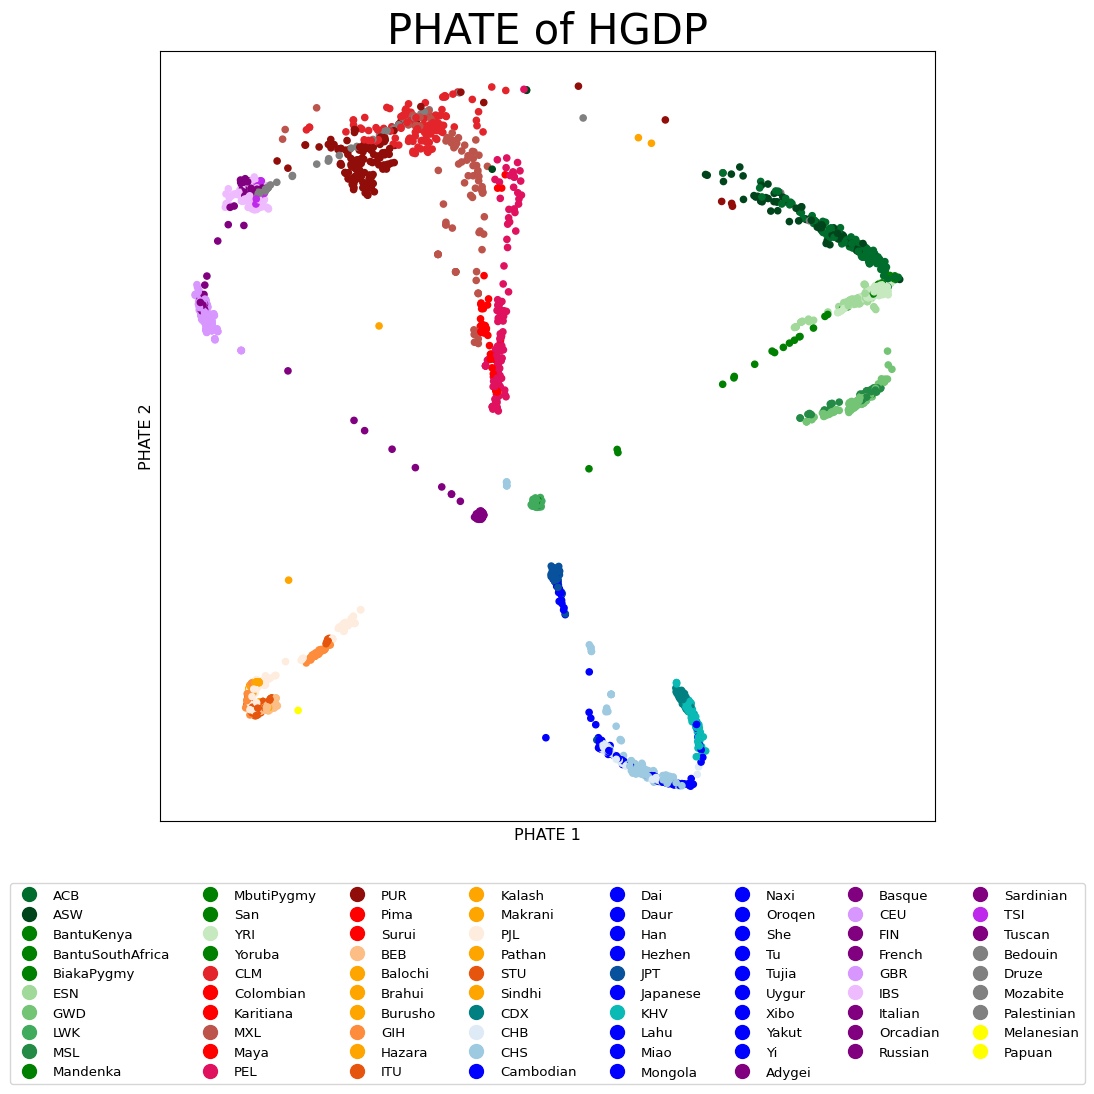

In [16]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(phate_emb2, 
                      s=20, 
                      cmap=pop_palette_hgdp_fine, ax=ax,
                      c=labels['Population'], 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

ax.set_title("PHATE of HGDP", fontsize=30)

In [17]:
pd.DataFrame({'id': all_samples['fid'][1:], 'PHATE1': phate_emb2[:,0], 'PHATE2': phate_emb2[:,1]}).to_csv(os.path.join(exp_path, fname) + 'PHATE_emb_fitall1kgp.csv')
print(os.path.join(exp_path, fname) + 'PHATE_emb_fitall1kgp.csv')

/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnetPHATE_emb_fitall1kgp.csv


## Remove Related Individuals + Fit on just 1KGP (proj HGDP)

In [18]:
dpath = '/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP'
unrelated_indvs = '1000G_unrelated_samples_set_2504.txt'

unrelated_list = pd.read_csv(os.path.join(dpath, unrelated_indvs), header=None)

In [19]:
unrelated_1kgp = all_samples.loc[1:,:]['fid'].isin(unrelated_list.values.flatten().tolist())

In [20]:
# Fit PCA model
pca_obj = PCA(n_components=100)  # Number of components to keep
pca_obj.fit(genotypes_array[1:,:][unrelated_1kgp])
pca_input = pca_obj.transform(genotypes_array[1:,:])

In [21]:
phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator.fit(pca_input[unrelated_1kgp])
phate_emb = phate_operator.transform(pca_input)

Running PHATE on 2501 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.37 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 0.42 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.14 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.15 seconds.
Calculated landmark operator in 1.94 seconds.
Calculating diffusion potential...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated diffusion potential in 0.69 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.99 seconds.
Calculating KNN search...
Calculated KNN search in 0.59 seconds.
Calculating affinities...
Calculated affinities in 0.14 seconds.


Text(0.5, 1.0, 'PHATE of HGDP')

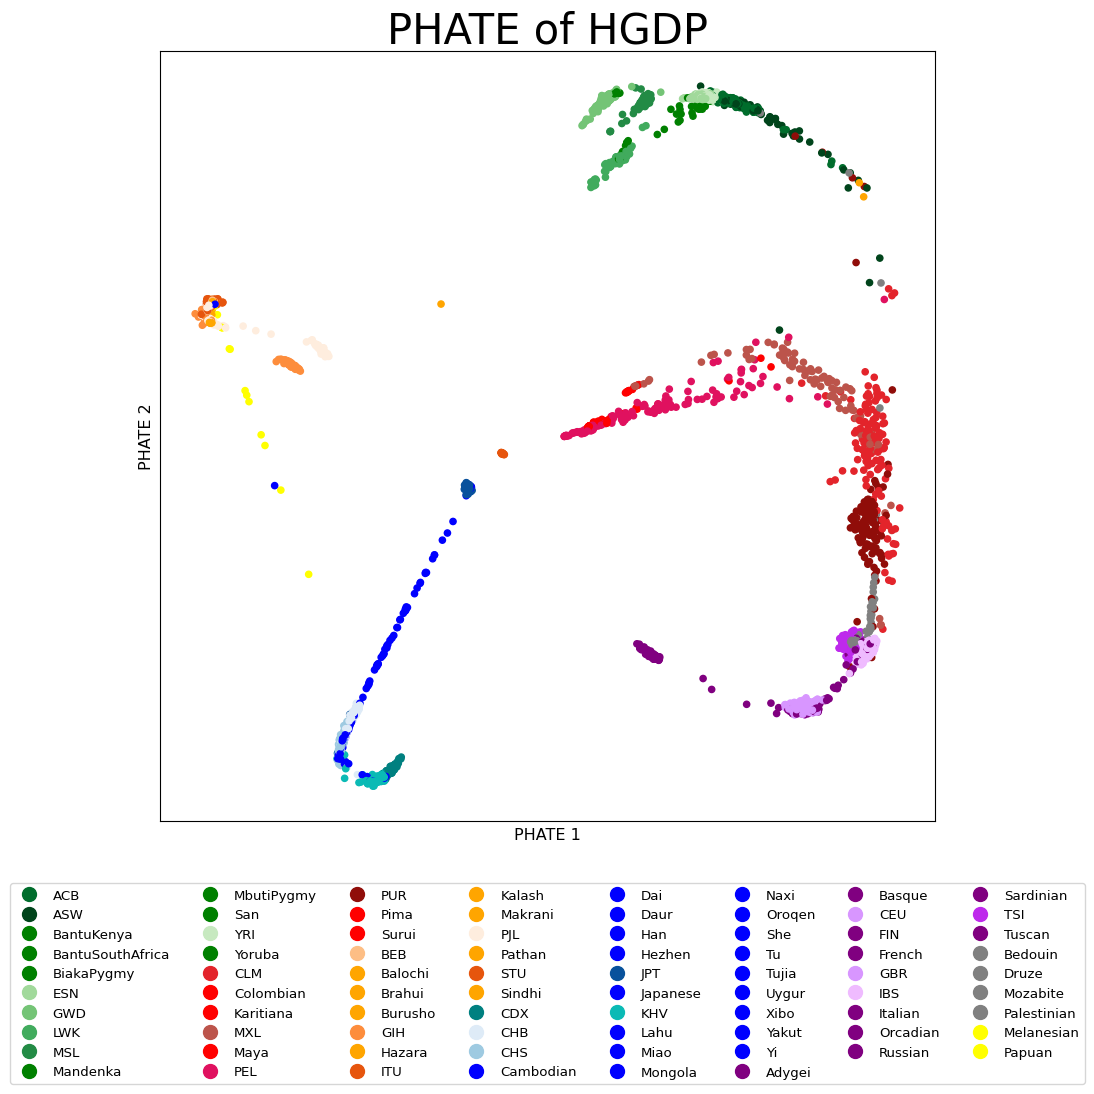

In [22]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(phate_emb, 
                      s=20, 
                      cmap=pop_palette_hgdp_fine, ax=ax,
                      c=labels['Population'], 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

ax.set_title("PHATE of HGDP", fontsize=30)

In [23]:
pd.DataFrame({'id': all_samples['fid'][1:], 'PHATE1': phate_emb[:,0], 'PHATE2': phate_emb[:,1]}).to_csv(os.path.join(exp_path, fname) + 'PHATE_emb_fitunrelated1kgp.csv')
print(os.path.join(exp_path, fname) + 'PHATE_emb_fitunrelated1kgp.csv')

/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnetPHATE_emb_fitunrelated1kgp.csv


## Remove Related Individuals + Fit on just 1KGP+HGDP

In [24]:
unrelated_1kgp_allhgdp = (unrelated_1kgp | (labels['Project'] == 'HGDP'))

In [25]:
# Fit PCA model
pca_obj = PCA(n_components=100)  # Number of components to keep
pca_obj.fit(genotypes_array[1:,:][unrelated_1kgp_allhgdp])
pca_input = pca_obj.transform(genotypes_array[1:,:])

In [26]:
phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator.fit(pca_input[unrelated_1kgp_allhgdp])
phate_emb = phate_operator.transform(pca_input)

Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.80 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 0.84 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.17 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.01 seconds.
Calculated landmark operator in 1.90 seconds.
Calculating diffusion potential...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated diffusion potential in 0.87 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.75 seconds.
Calculating KNN search...
Calculated KNN search in 0.94 seconds.
Calculating affinities...
Calculated affinities in 0.05 seconds.


Text(0.5, 1.0, 'PHATE of HGDP')

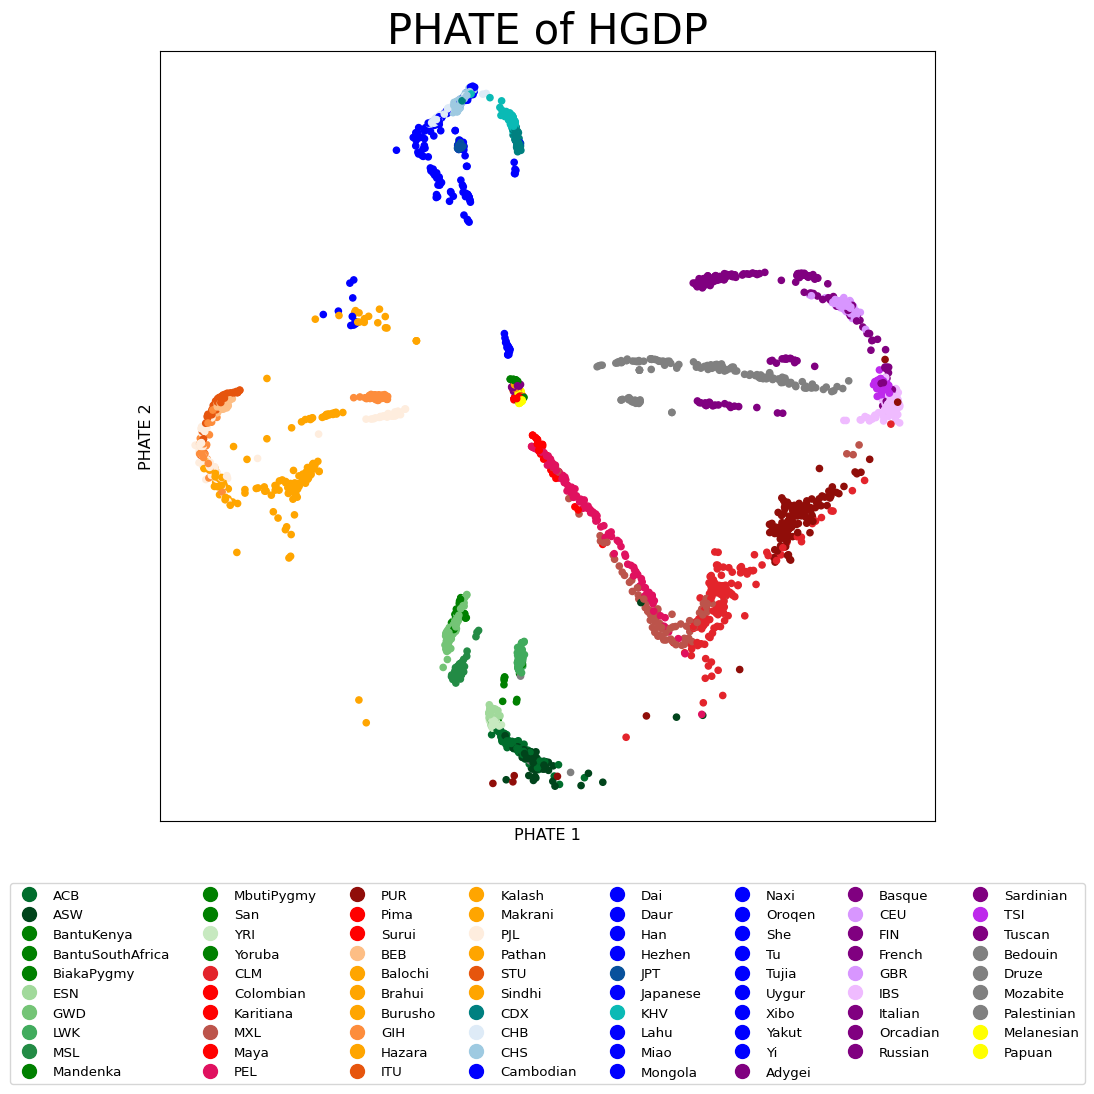

In [27]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(phate_emb, 
                      s=20, 
                      cmap=pop_palette_hgdp_fine, ax=ax,
                      c=labels['Population'], 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

ax.set_title("PHATE of HGDP", fontsize=30)

Text(0.5, 1.0, 'PHATE of HGDP')

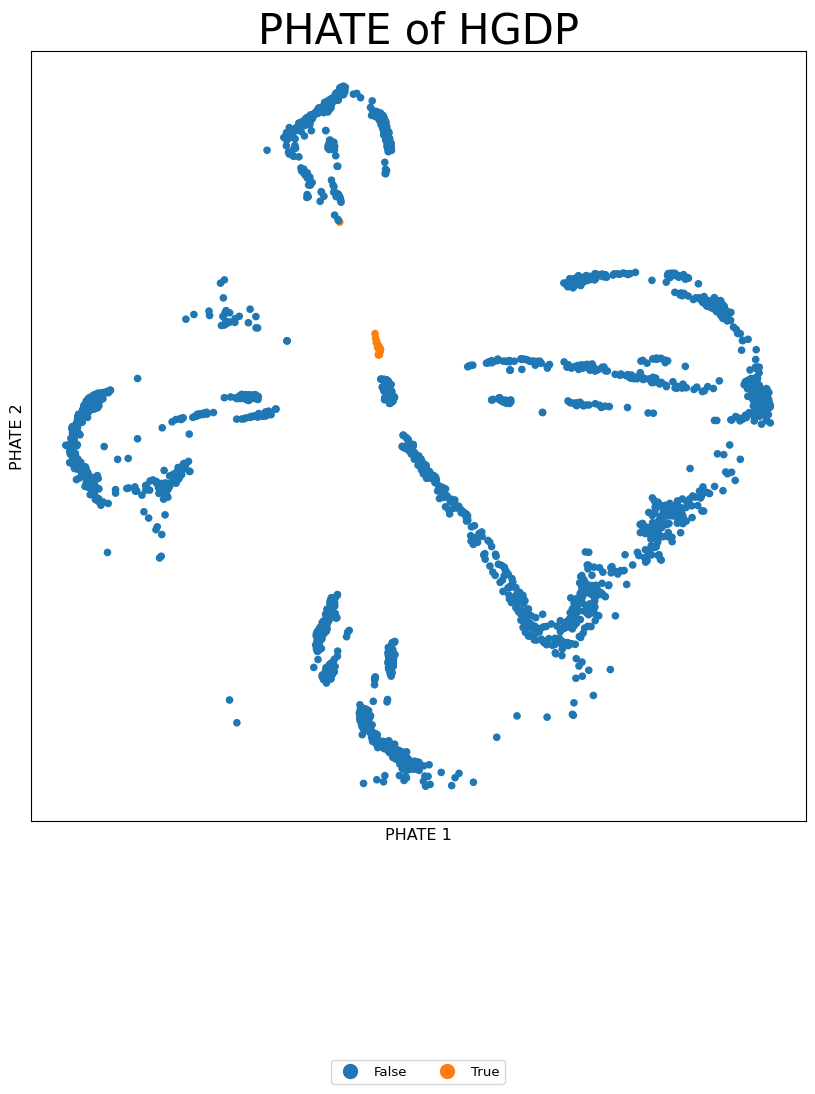

In [55]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(phate_emb, 
                      s=20, 
                      ax=ax,
                      c=labels['Population']=='Yakut', 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

ax.set_title("PHATE of HGDP", fontsize=30)

Text(0.5, 1.0, 'PHATE of HGDP')

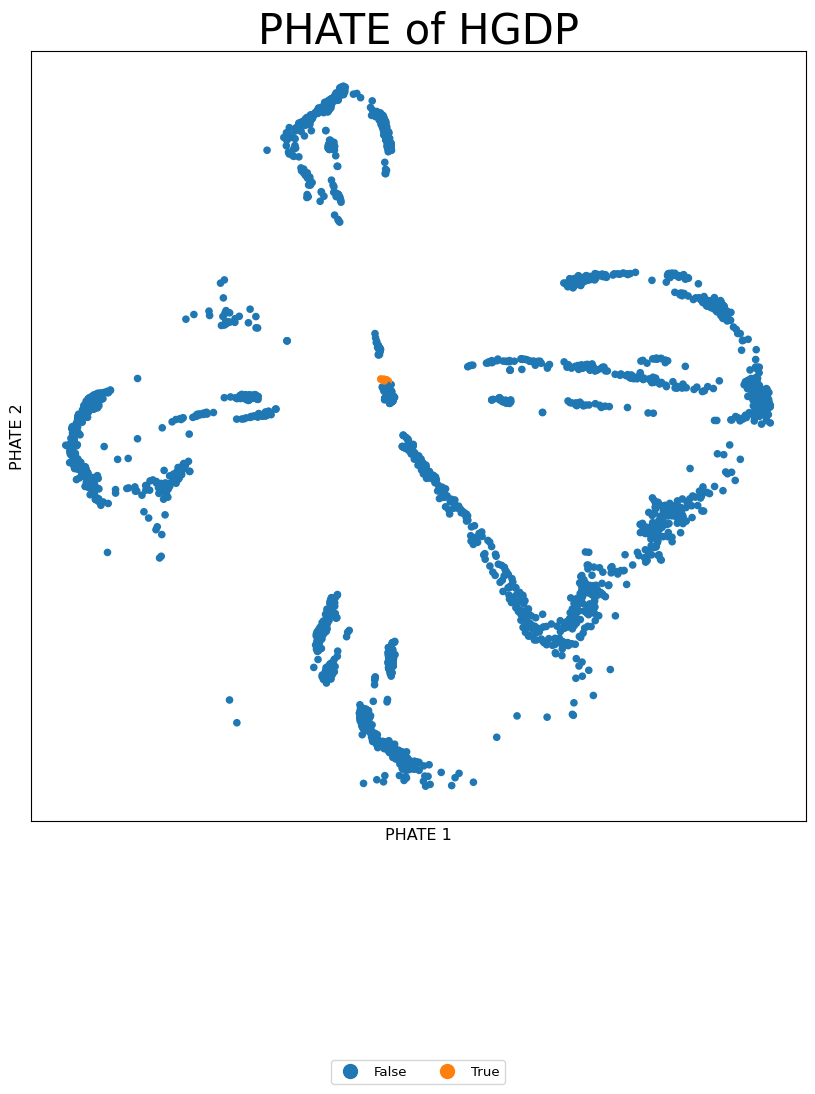

In [56]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(phate_emb, 
                      s=20, 
                      ax=ax,
                      c=labels['Population']=='BiakaPygmy', 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

ax.set_title("PHATE of HGDP", fontsize=30)

Text(0.5, 1.0, 'PHATE of HGDP')

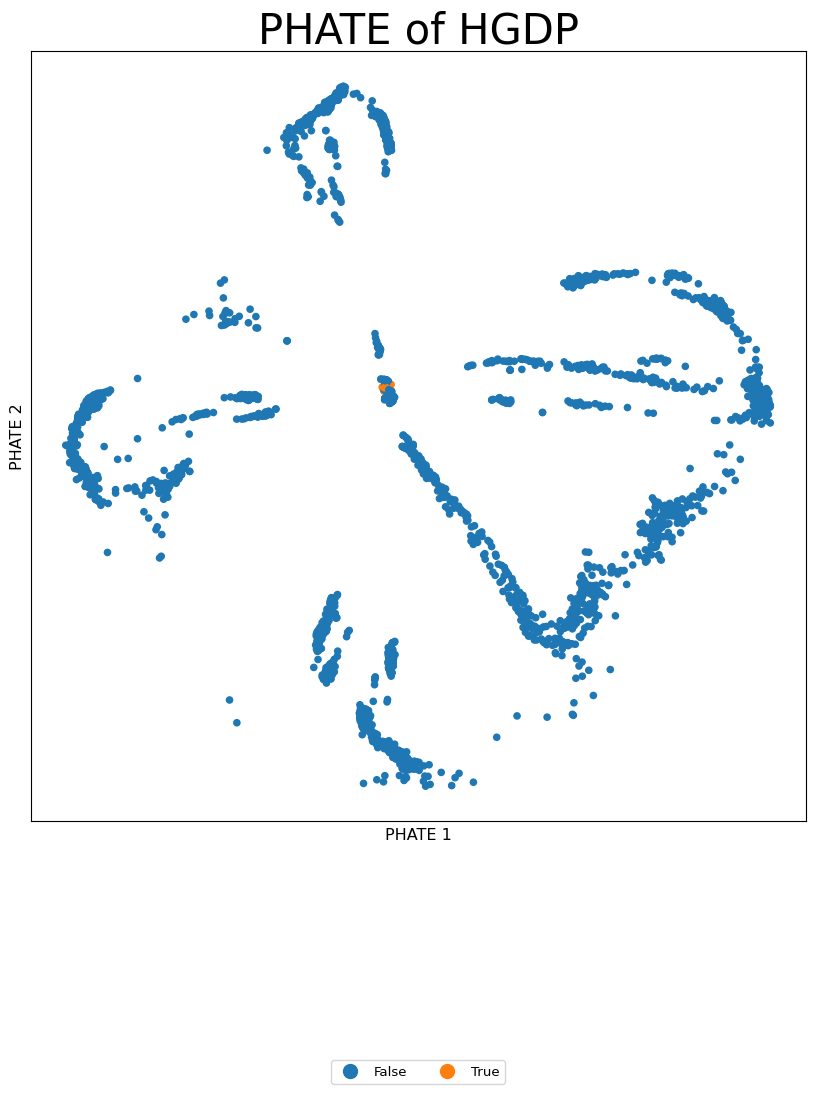

In [57]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(phate_emb, 
                      s=20, 
                      ax=ax,
                      c=labels['Population']=='Sardinian', 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

ax.set_title("PHATE of HGDP", fontsize=30)


Text(0.5, 1.0, 'PHATE of HGDP')

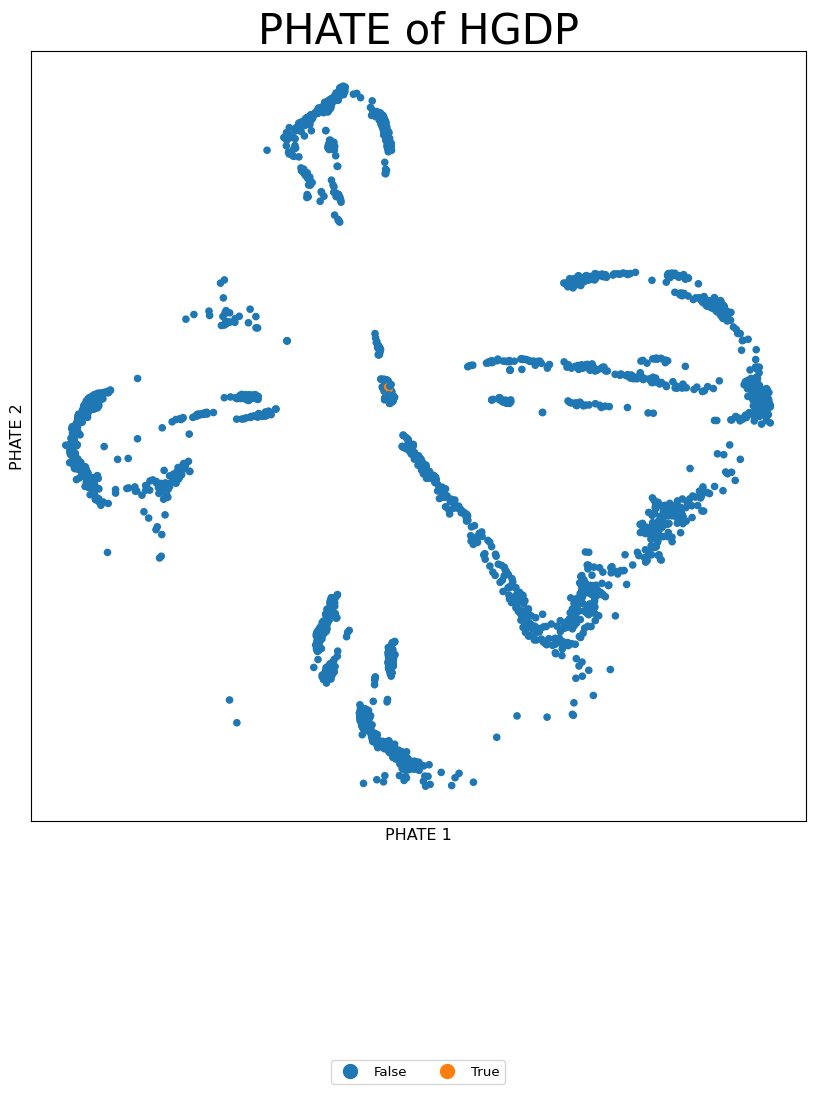

In [58]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(phate_emb, 
                      s=20, 
                      ax=ax,
                      c=labels['Population']=='Kalash', 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

ax.set_title("PHATE of HGDP", fontsize=30)

In [28]:
pd.DataFrame({'id': all_samples['fid'][1:], 'PHATE1': phate_emb[:,0], 'PHATE2': phate_emb[:,1]}).to_csv(os.path.join(exp_path, fname) + 'PHATE_emb_fitunrelated1kgp+allhgdp.csv')
print(os.path.join(exp_path, fname) + 'PHATE_emb_fitunrelated1kgp+allhgdp.csv')

/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnetPHATE_emb_fitunrelated1kgp+allhgdp.csv


## Look at Points in Middle

In [29]:
embs = pd.read_csv(os.path.join(exp_path, fname) + 'PHATE_emb_fitunrelated1kgp+allhgdp.csv')
embs_coords = embs[['PHATE1','PHATE2']].values

In [30]:
x_min = -0.005
x_max = 0.001
y_min = 0
y_max = 0.01
in_middle = (phate_emb[:,0] < x_max) & (phate_emb[:,0] > x_min) & (phate_emb[:,1] < y_max) & (phate_emb[:,1] > y_min)

In [31]:
import matplotlib.patches as patches

def constraints_to_rectangle(x_min, x_max, y_min, y_max, **kwargs):
    """
    Converts boundary constraints into a Rectangle patch.

    Parameters:
    x_min (float): Minimum x value.
    x_max (float): Maximum x value.
    y_min (float): Minimum y value.
    y_max (float): Maximum y value.
    kwargs: Additional keyword arguments for the Rectangle patch (e.g., color, alpha).

    Returns:
    Rectangle: A matplotlib Rectangle patch.
    """
    # Calculate the lower-left corner, width, and height
    lower_left = (x_min, y_min)
    width = x_max - x_min
    height = y_max - y_min

    # Create and return the Rectangle patch
    return patches.Rectangle(lower_left, width, height, **kwargs)

Text(0.5, 1.0, 'PHATE of HGDP')

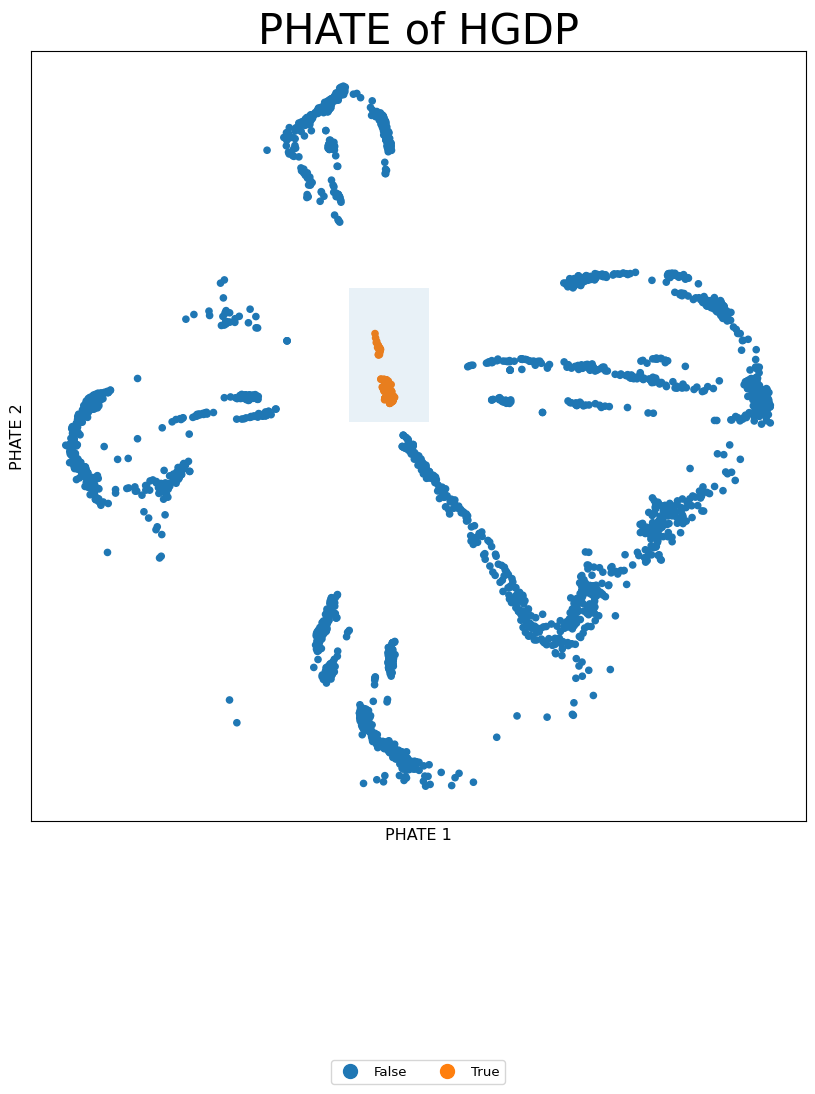

In [32]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(embs_coords, 
                      s=20, 
                      ax=ax,
                      c=in_middle, 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

# Create a Rectangle patch
rect = constraints_to_rectangle(x_min, x_max, y_min, y_max, alpha=0.1)

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_title("PHATE of HGDP", fontsize=30)

In [33]:
labels[in_middle]

,sample,Project,Study_Region,Population,Genetic_region
1855,HG03717,1000_Genomes,SAS,ITU,CSA
1856,HG03718,1000_Genomes,SAS,ITU,CSA
1892,HG03772,1000_Genomes,SAS,ITU,CSA
1893,HG03773,1000_Genomes,SAS,ITU,CSA
1902,HG03784,1000_Genomes,SAS,ITU,CSA
...,...,...,...,...,...
3096,LP6005592-DNA_C03,HGDP,Africa,MbutiPygmy,AFR
4146,SS6004471,HGDP,Africa,MbutiPygmy,AFR
4147,SS6004473,HGDP,Africa,San,AFR
4148,SS6004474,HGDP,Europe,Sardinian,EUR


In [34]:
labels[in_middle].groupby('Population').count()['sample']

Population
BiakaPygmy    26
ITU           16
Kalash        23
Karitiana     11
Lahu           8
MbutiPygmy    14
Melanesian    13
Papuan        17
Pima          14
San            6
Sardinian     27
Surui          8
Yakut         24
Name: sample, dtype: int64

In [35]:
labels[in_middle].groupby('Genetic_region').count()['sample']

Genetic_region
AFR    46
AMR    33
CSA    39
EAS    32
EUR    27
OCE    30
Name: sample, dtype: int64

In [36]:
labels[in_middle].groupby('Project').count()['sample']

Project
1000_Genomes     16
HGDP            191
Name: sample, dtype: int64

In [37]:
all_samples.loc[1:,:][in_middle]

,fid,iid,father,mother,gender,status
1855,HG03717,HG03717,0,0,0,-9
1856,HG03718,HG03718,0,0,0,-9
1892,HG03772,HG03772,0,0,0,-9
1893,HG03773,HG03773,0,0,0,-9
1902,HG03784,HG03784,0,0,0,-9
...,...,...,...,...,...,...
3096,LP6005592-DNA_C03,LP6005592-DNA_C03,0,0,0,-9
4146,SS6004471,SS6004471,0,0,0,-9
4147,SS6004473,SS6004473,0,0,0,-9
4148,SS6004474,SS6004474,0,0,0,-9


## Look at points in middle for PHATE fitted on related samples

In [38]:
embs = pd.read_csv(os.path.join(exp_path, fname) + 'PHATE_emb_all1kgp+hgdp.csv')
embs_coords = embs[['PHATE1','PHATE2']].values

In [39]:
x_min = -0.007
x_max = 0.002
y_min = -0.005
y_max = 0.01
in_middle2 = (embs_coords[:,0] < x_max) & (embs_coords[:,0] > x_min) & (embs_coords[:,1] < y_max) & (embs_coords[:,1] > y_min)

Text(0.5, 1.0, 'PHATE of HGDP')

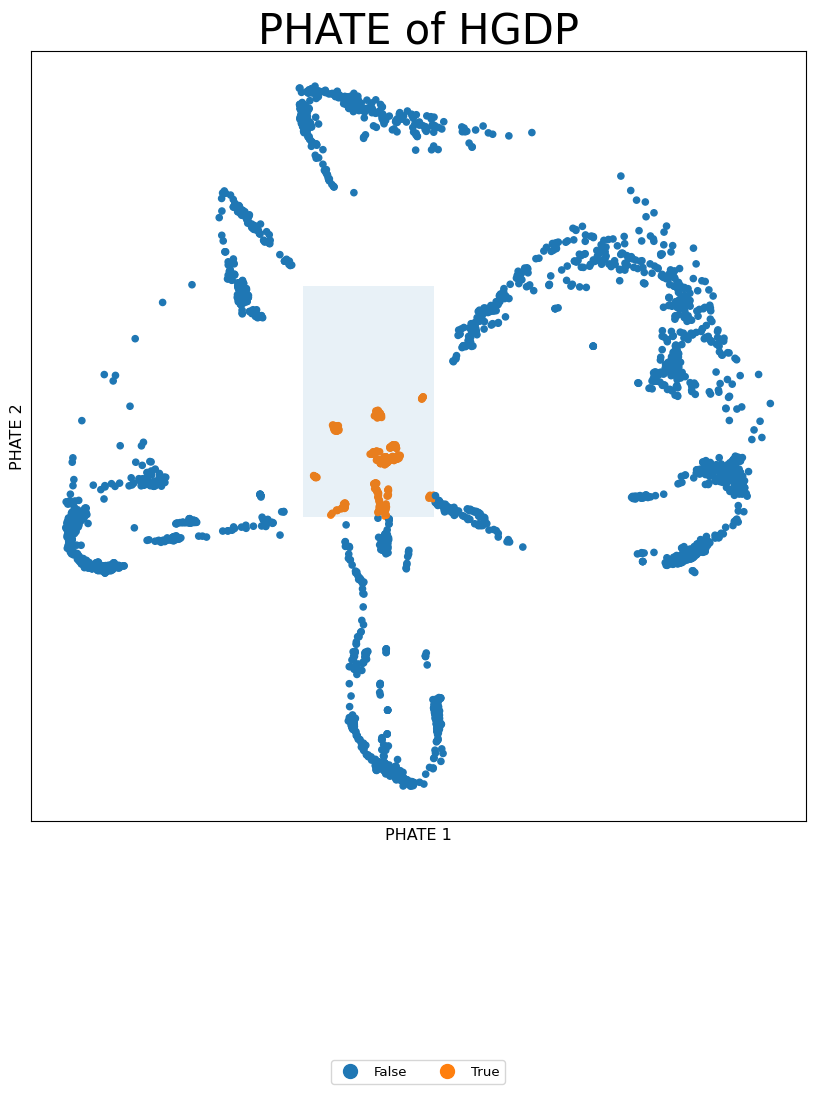

In [40]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(embs_coords, 
                      s=20, 
                      ax=ax,
                      c=in_middle2, 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

# Create a Rectangle patch
rect = constraints_to_rectangle(x_min, x_max, y_min, y_max, alpha=0.1)

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_title("PHATE of HGDP", fontsize=30)

In [41]:
print(labels[in_middle2]['sample'].isin(labels[in_middle]['sample']).sum()/in_middle2.sum())
print(labels[in_middle]['sample'].isin(labels[in_middle2]['sample']).sum()/in_middle.sum())

0.2965779467680608
0.7536231884057971


In [42]:
in_middle2.sum(), in_middle.sum()

(526, 207)

In [43]:
labels[in_middle2].groupby('Genetic_region').count()['sample']

Genetic_region
AFR    157
AMR     40
CSA     23
EAS    163
EUR     35
MID     78
OCE     30
Name: sample, dtype: int64

In [44]:
labels[in_middle2].groupby('Project').count()['sample']

Project
1000_Genomes    226
HGDP            300
Name: sample, dtype: int64

In [45]:
labels['in_middle'] = in_middle2
labels['1kgp_related'] = ((~unrelated_1kgp) & (labels['Project'] == '1000_Genomes'))

In [46]:
labels[labels['in_middle']].groupby('1kgp_related').count()['sample']

1kgp_related
False    521
True       5
Name: sample, dtype: int64

Text(0.5, 1.0, 'PHATE of HGDP')

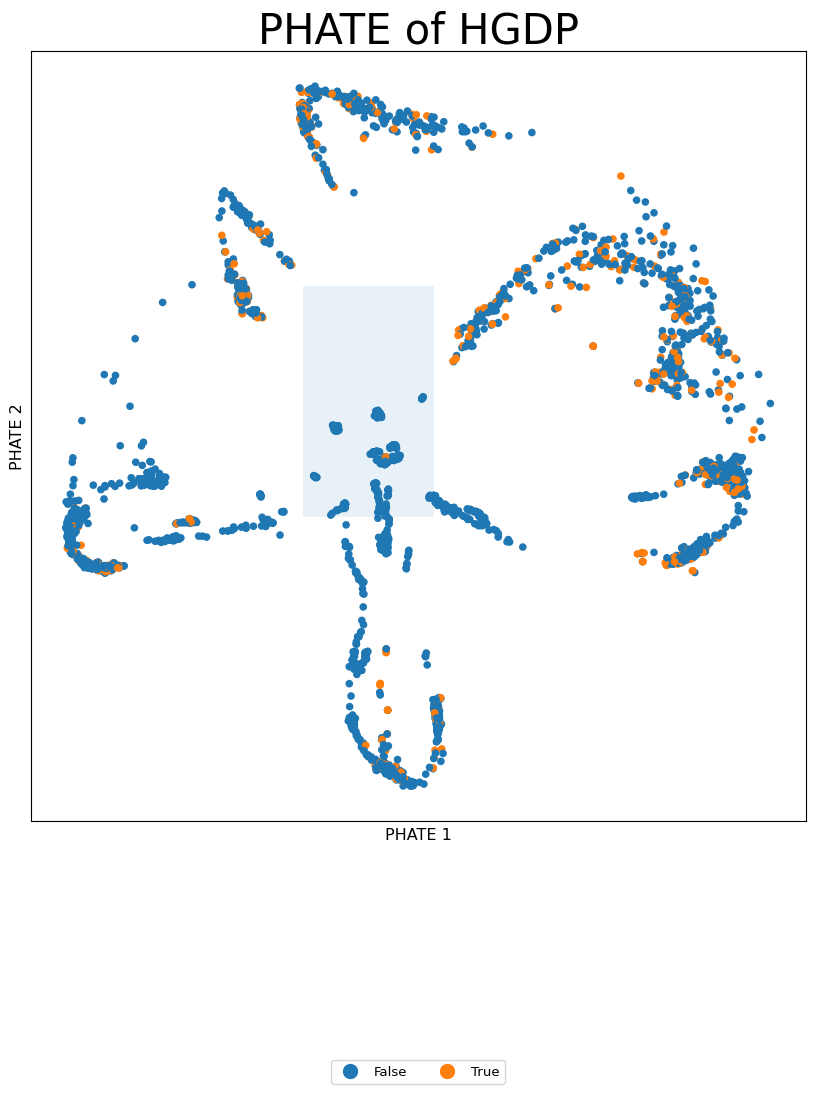

In [47]:
fig, ax = plt.subplots(figsize=(10, 10), gridspec_kw={'wspace': 0.08})

scprep.plot.scatter2d(embs_coords, 
                      s=20, 
                      ax=ax,
                      c=labels['1kgp_related'], 
                      xticks=False, 
                      yticks=False,
                      legend=True, 
                      legend_loc='lower center', 
                      legend_anchor=(0.5, -0.35), 
                      legend_ncol=8,
                      label_prefix="PHATE ", 
                      fontsize=8)

# Create a Rectangle patch
rect = constraints_to_rectangle(x_min, x_max, y_min, y_max, alpha=0.1)

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_title("PHATE of HGDP", fontsize=30)